<h1><center> Different methods for regression </center></h1> 

In this lab, we are going to test different methods such as Principal Component Analysis (PCA), Forward Variable Selection, Ridge and Lasso, and we will compare them with the classical Ordinary Least Squares (OLS).

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.stats import norm
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D

In the following, when a prediction risk is computed:

$$R_{pred}(\widehat{\theta}_{n}, \theta^{*}) = \frac{\mathbb{E}(|| Y^{*} - \widehat{Y} ||^{2})}{n}$$

where $\theta^{*}$ is the true parameters vector, $\widehat{\theta}_{n}$ the estimator computed, $Y^{*}$ the true output, $\widehat{Y}$ the prediction obtained with $\widehat{\theta}_{n}$ and $n$ the number of observations.

<h2> Data set contaminated by the robot </h2>

We work with the data set <tt>diabetes</tt> accessible in python. The initial data consists of $n = 442$ patients and $p = 10$ covariates. The output variable $Y$ is a score reflecting the disease progressing. For fun, a bad robot has contaminated the data set by adding $200$ inappropriate exploratory variables. Since simple noising the data was not sufficient for the robot, he arbitrarily permuted the variables. To complete the picture, the robot has erased any trace of his villainous act and thus we do not know which variables are relevant. The new data set contains $n = 442$ patients and $p = 210$ covariates denoted by $X$. The goal of this lab is to retrieve the relevant variables.

Let import the data set <tt>data_set.csv</tt>. The last column is the output variable $Y$. The other columns are the exploratory variables.

In [2]:
df = pd.read_csv('data_set.csv', sep = ',', header = None )
df.head()

0         1         2         3         4         5         6    \
0 -1.298173 -0.162249  1.223379  1.355554  1.080171  0.634979  0.298741   
1  0.166951 -0.338060 -0.618867  0.759366  1.134281 -0.536844 -0.075120   
2 -0.416177 -0.205659 -1.282226  1.675500  1.523746  0.192029 -0.235840   
3  0.867184 -0.398667  0.093501  0.025971  1.852099  0.789774  0.801775   
4  1.193282 -0.936980 -0.725039  0.766078  0.223489 -1.584622  1.146866   

        7         8         9    ...         201       202       203  \
0  0.548270  0.731773  1.018645  ...    0.588278  0.210106  1.861458   
1  0.970251 -0.327487  0.717310  ...   -0.251054 -0.825716  0.339139   
2 -1.954626 -0.853309  0.892791  ...    1.283837  0.372516 -0.652557   
3  0.376711  0.853689  0.247953  ...    0.446582  0.334733  0.399074   
4  0.086136 -0.088780 -0.945066  ...    0.786157 -1.058179 -0.155788   

        204       205       206       207       208       209    210  
0 -0.436399  0.279299 -1.416020 -2.332363  0.215096 -0.693319  151.0  
1  1.119430  0.225958 -0.822288  0.382838 -0.718829 -0.188993   75.0  
2 -2.579347  0.139267 -1.901196  0.048210  0.220205  0.471588  141.0  
3 -0.884172  0.723819  1.316367  0.088218  0.619496  1.061662  206.0  
4 -0.642504  2.040010 -1.703110 -1.901502  1.778811 -0.489853  135.0  

[5 rows x 211 columns]

Are the exploratory variables centered? Normalized? And the output variable?

In [5]:
covariates = df[df.columns[0:210]]
scores = df[df.columns[-1]]

means = covariates.mean()
variances = covariates.var()
is_centered = sum(means < 10e-15) == means.size
is_normalized = sum(np.abs(variances - 1) < 10e-3) == variances.size
print('Are the exploratory variables centered ? ' + str(is_centered) + '\n' +
      'Are the exploratory variables normalized ? ' + str(is_normalized) + '\n')

mean_score = scores.mean()
variance_score = scores.var()
print('Is the output variable centered ? ' + str(mean_score < 10e-15) + '\n'+
      'Is the output variable normalized ? ' + str(np.abs(variance_score - 1 < 10e-3)))

Are the exploratory variables centered ? True
Are the exploratory variables normalized ? True

Is the output variable centered ? False
Is the output variable normalized ? False


Now we provide a scatter plot of four randomly chosen exploratory variables and the output variable.

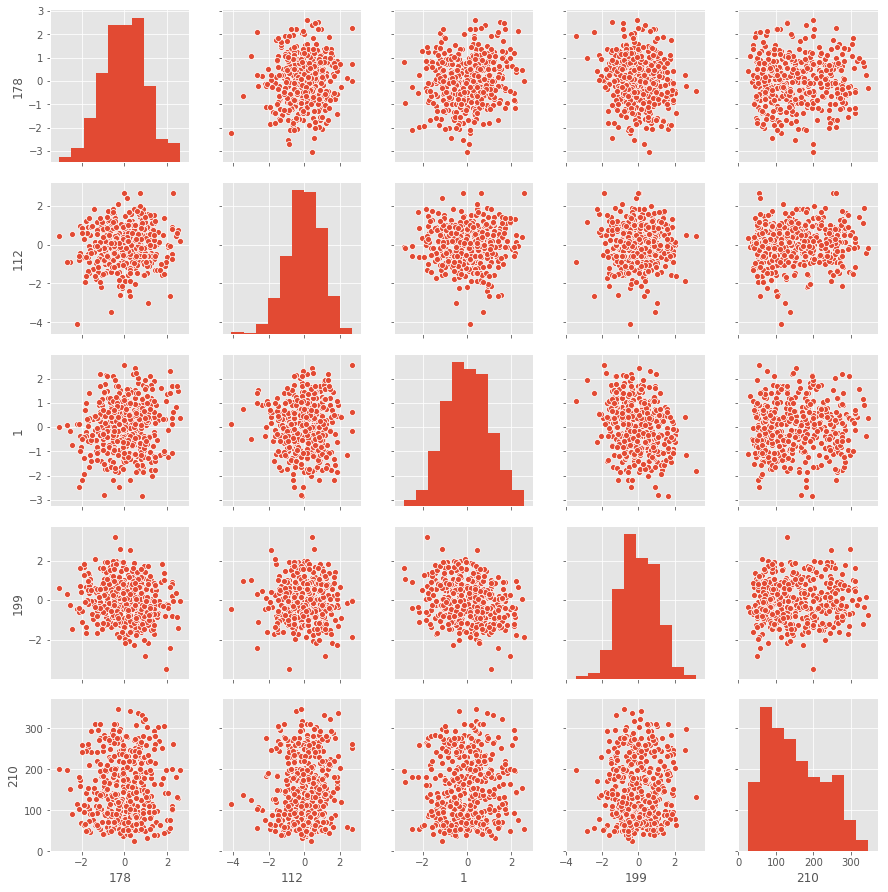

In [6]:
rd_index = np.random.choice(covariates.columns, 4, False)
sb.pairplot(data = pd.concat([covariates[covariates.columns[rd_index]], scores], axis = 1))

When the random choice gives us false covariates (added by the robot), the histograms of the four covariates show us that they follow gaussian distributions and that they are not correlated. Besides, when we plot a covariate with the output variable, we have a different distribution but we still have no correlation, because the covariate is just a noise (that is why we can tell the covariate has been added by the robot) . If we get a real covariate, we would see a correlation between this one and the score.

Let create two samples: one to learn the model $X_{train}$ and one to test it $X_{test}$. We put $20\%$ of the data set in the test sample. Note that the new sample of the covariates $X_{train}$ is not normalized. In what follows, we will pay attention to include the intercept in the regression models.

In [7]:
training_set, test_set, training_score, test_score = train_test_split(covariates.values, scores.values, test_size = 0.2)

print('The shape of the training set is : ' + str(training_set.shape) + '\n' +
      'The shape of the test set is : ' + str(test_set.shape))

The shape of the training set is : (353, 210)
The shape of the test set is : (89, 210)


<h3> PCA </h3>

Let provide the covariance matrix for $X_{train}$. Then, we plot the eigenvalues of the covariance (or correlation) matrix in descending order. Finally, we explain why it makes sense to keep only first $PCA$ variables. In what follows, we will keep $60$ variables.

Here are the eigenvalues of the covariance matrix in a decreasing order : 


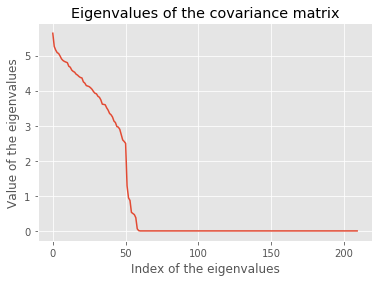

In [8]:
cov_matrix = np.cov(training_set.T)
eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
eig_values = np.array(list(reversed(eig_values)))
eig_vectors = np.array(list(reversed(eig_vectors)))

print('Here are the eigenvalues of the covariance matrix in a decreasing order : ')

plt.figure()
plt.title('Eigenvalues of the covariance matrix')
plt.xlabel('Index of the eigenvalues')
plt.ylabel('Value of the eigenvalues')
plt.plot(eig_values)

It makes sense to keep only first $PCA$ variables because these are the ones with the highest eigenvalues and the ones that carry the information (if an eigenvalue is null, it means that the columns of the covariance matrix do not form a linearly independent set and that we have redundant information, we can then remove a dimension).

Let apply the method "$PCA$ before $OLS$" that consists in applying $OLS$ with $Y$ and $X_{train}V_{(1:60)}$, where $V_{(1:60)}$ contains the eigenvectors (associated with the $60$ largest eigenvalues) of the covariance matrix. We run linear regression (with intercept), then we plot the values of the coefficients (but not for the intercept). On another graph, we do the same using the classical $OLS$.

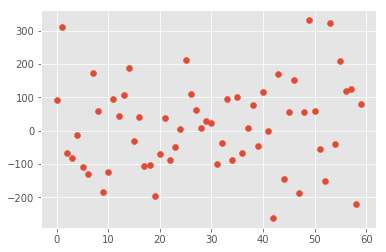

In [9]:
pca_training_set = training_set@(eig_vectors[0:60].T)
pca_test_set = test_set@(eig_vectors[0:60].T)
pca_ols = LinearRegression().fit(pca_training_set, training_score)
ols = LinearRegression().fit(training_set, training_score)

plt.scatter(range(len(pca_ols.coef_)), pca_ols.coef_)

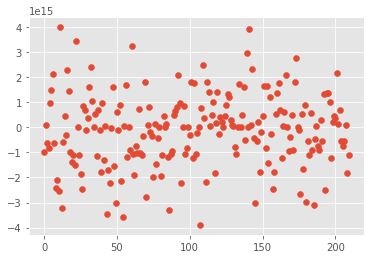

In [10]:
plt.scatter(range(len(ols.coef_)), ols.coef_)

Let provide the intercept values for the $2$ regressions. Also, let provide the mean value of the output variable $Y$ (for the train set). Exceptionally for the two following cells, we center and normalize the variables after $PCA$ (the low dimensional ones). Then we run the regression and verify that the intercept is equal to the average of $Y$ on the train set.

In [11]:
print('With PCA before OLS, the intercept is : ' + str(pca_ols.intercept_) + '\n' +
      'With only OLS, the intercept is : ' + str(ols.intercept_))

print('The mean of the output variable from the training set is : ' + str(training_score.mean()))

With PCA before OLS, the intercept is : 149.93423925664257
With only OLS, the intercept is : 149.59224504249292
The mean of the output variable from the training set is : 149.52974504249292


The two intercepts are not equal, even though they are close.

In [12]:
#we normalize the data
norm_pca_training_set = (pca_training_set - pca_training_set.mean(axis = 0))/pca_training_set.std(axis = 0)
norm_pca = LinearRegression().fit(norm_pca_training_set, training_score)

print('The intercept after normalization is : ' + str(norm_pca.intercept_) + '\n' +
      'The mean of the training score is : ' + str(training_score.mean()) + '\n' +
      'Are they equal ? ' + str(np.abs(norm_pca.intercept_ - training_score.mean()) < 10e-4))

The intercept after normalization is : 149.5297450424929
The mean of the training score is : 149.52974504249292
Are they equal ? True


For the two methods ($OLS$ and $PCA$ before $OLS$), we plot the density of the residuals of the prediction for the test sample. Then, we calculate the determination coefficient for the test sample and the prediction risk for the test sample.

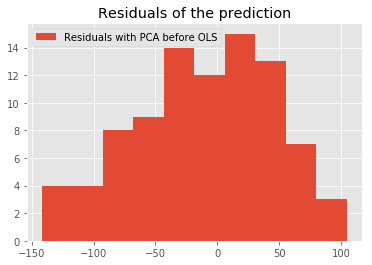

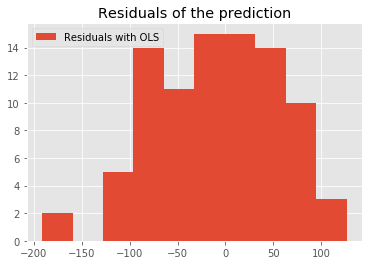

In [13]:
prediction_pca_ols = pca_ols.predict(pca_test_set)
prediction_ols = ols.predict(test_set)

residuals_pca_ols = prediction_pca_ols - test_score
residuals_ols = prediction_ols - test_score

plt.figure()
plt.title('Residuals of the prediction')
plt.hist(residuals_pca_ols, label = 'Residuals with PCA before OLS')
plt.legend(loc = 'best')

plt.figure()
plt.title('Residuals of the prediction')
plt.hist(residuals_ols, label = 'Residuals with OLS')
plt.legend(loc = 'best')

In [14]:
ols_det_coef = ols.score(X = test_set, y = test_score)
pca_ols_det_coef = pca_ols.score(X = pca_test_set, y = test_score)

print('The determination coefficient for the test sample, with only OLS is : ' + str(ols_det_coef) + '\n' + 
      'The determination coefficient for the test sample, with PCA before OLS is : ' + str(pca_ols_det_coef) + '\n')

ols_prediction_risk = (1/test_set.shape[0]) * np.mean(residuals_ols**2)
pca_ols_prediction_risk = (1/test_set.shape[0]) * np.mean(residuals_pca_ols**2)

print('The prediction risk with OLS is : ' + str(ols_prediction_risk) + '\n' +
      'The prediction risk with PCA before OLS is : ' + str(pca_ols_prediction_risk))

The determination coefficient for the test sample, with only OLS is : 0.35729192953959676
The determination coefficient for the test sample, with PCA before OLS is : 0.4809544549822186

The prediction risk with OLS is : 46.74624993915383
The prediction risk with PCA before OLS is : 37.75187194992657


<h3> Forward Variable Selection </h3>

Let program the method of the forward variable selection. We use the test statistics of the test for nullity. For the moment, we do not define the stop criterion for the method, i.e. we add a variable at each time until all the variables are selected. Then we provide the order of the variable selection.

In [15]:
def forward_variable_selection_without_stop(Y, X) :
    n, p = X.shape[0], X.shape[1]
    
    #initialization
    r = Y.copy()
    S = []
    A = range(0, p)
    
    while (len(A) > len(S)) :
        
        #we store the values to get the argmax
        theta = []
        tests = []
        
        for k in A :
            if k not in S :
                pk = 1 #we consider one feature
                current_feature = X[:, k].reshape(-1, 1)
                reg = LinearRegression().fit(current_feature, r)

                theta_nk = reg.coef_[0]
                s_nk = np.sqrt(n/np.linalg.norm(X[:, k])**(2)) #the gram matrix is 1x1 so we compute it directly
                sigma_nk = np.linalg.norm(r - reg.predict(current_feature))/np.sqrt(n - pk - 1) #unbiased estimator of std
                test_nk = np.sqrt(n) * abs(theta_nk)/(s_nk*sigma_nk) #formula from the course
                
                theta.append(theta_nk)
                tests.append(test_nk)
            else :
                #to have the right size for when we will use the argmax
                theta.append(0)
                tests.append(0)

        k_tilde = np.argmax(tests)
        r -= theta[k_tilde]*X[:, k_tilde]
        
        S.append(k_tilde)
    
    return S

In [16]:
S_nostop = forward_variable_selection_without_stop(training_score, training_set)

print('The order of the variable selection is : ' + str(S_nostop))

The order of the variable selection is : [58, 123, 13, 208, 133, 167, 112, 135, 184, 111, 30, 192, 204, 174, 183, 159, 84, 134, 117, 69, 186, 196, 158, 77, 124, 51, 85, 10, 153, 99, 132, 121, 164, 181, 66, 41, 173, 209, 82, 127, 32, 71, 23, 34, 61, 17, 129, 145, 79, 0, 101, 160, 197, 86, 63, 55, 27, 155, 151, 7, 39, 156, 104, 125, 171, 89, 4, 187, 97, 146, 207, 80, 130, 140, 52, 202, 152, 38, 182, 206, 116, 126, 150, 9, 175, 40, 110, 21, 47, 120, 191, 203, 162, 178, 94, 16, 115, 168, 103, 91, 43, 118, 131, 88, 28, 59, 201, 65, 48, 165, 78, 75, 5, 98, 96, 193, 105, 148, 198, 205, 176, 50, 114, 53, 106, 67, 70, 57, 64, 188, 62, 141, 20, 33, 157, 6, 169, 136, 189, 74, 2, 128, 24, 143, 14, 1, 25, 144, 29, 36, 42, 35, 122, 179, 31, 113, 87, 19, 56, 170, 54, 60, 68, 3, 149, 177, 26, 49, 95, 100, 195, 72, 18, 37, 109, 200, 185, 73, 46, 161, 12, 194, 102, 190, 8, 22, 147, 163, 180, 142, 108, 81, 45, 107, 76, 93, 139, 44, 154, 172, 11, 90, 92, 83, 15, 137, 166, 119, 199, 138]


Now we define a stop criterion: we choose to stop if the $p$-value is larger than $0.1$. Then, we illustrate the method providing $(i)$ the $3$ graphs of the test statistics obtained when selecting the $1^{st}$, $2^{nd}$ and $3^{rd}$ variables (in abscissa: the indices of the variables; in the ordinate: the value of the test statistics), $(ii)$ the graphs of the first $50$ $p$-values (each associated to a selected variable). On the same plot, we trace the horizontal line with the ordinate $0.1$. Finally, we provide the list of the selected variables.

In [17]:
def forward_variable_selection(Y, X, p_stop = 0.1, plot = True) :
    n, p = X.shape[0], X.shape[1]
    
    #initialization
    r = Y.copy()
    S = []
    A = range(0, p)
    
    #just an adaptation due to the plot
    count = len(S)
    count_plot = 0
    
    min_pvalues = []
    
    while (len(A) > count) :
        
        #we store the values to get the argmax
        theta = []
        tests = []
        p_values = []
        
        for k in A :
            if k not in S :
                pk = 1 #we consider one feature
                current_feature = X[:, k].reshape(-1, 1)
                reg = LinearRegression().fit(current_feature, r)

                theta_nk = reg.coef_[0]
                s_nk = np.sqrt(n/np.linalg.norm(X[:, k])**(2)) #the gram matrix is 1x1 so we compute it directly
                sigma_nk = np.linalg.norm(r - reg.predict(current_feature))/np.sqrt(n - pk - 1) #unbiased estimator of std
                test_nk = np.sqrt(n) * abs(theta_nk)/(s_nk*sigma_nk) #formula from the course
                
                theta.append(theta_nk)
                tests.append(test_nk)
                p_values.append(2*(1 - norm.cdf(test_nk)))
            else :
                #to have the right size for when we will use the argmax
                theta.append(0)
                tests.append(0)        
                
        min_p = min(p_values)
        min_pvalues.append(min_p)
        
        if (min_p > p_stop) and (plot == False) :
            return S
        
        k_tilde = np.argmax(tests)
        r -= theta[k_tilde]*X[:, k_tilde]
        count += 1
        
        if (plot == True) and (count_plot < 3) : #we plot the values of the tests for the three first steps
            count_plot += 1
            plt.figure()
            plt.title('Values of the tests during step ' + str(count_plot))
            plt.xlabel('Index of the variables')
            plt.ylabel('Value of the test')
            plt.plot(tests, marker = '+', label = 'Test values', linewidth = 0.7)
            plt.vlines(ymin = 0, ymax = max(tests)+1, x = np.argmax(tests), linewidth = 2, color = 'b', label = 'Variable ' + str(k_tilde) + ' selected')
            plt.legend(loc = 'upper left')
            
        if (min_p <= p_stop) :
            S.append(k_tilde)
            
    plt.figure()
    plt.title('Evolution of the smallest p-value with the number of steps')
    plt.xlabel('Number of the step')
    plt.ylabel('p-value of the selected variable')
    plt.scatter(x = range(0, 50), y = min_pvalues[0:50], marker = '+', label = 'p-values')
    plt.hlines(xmin = 0, xmax = 50, y = 0.1, linewidth = 1, color = 'b', label = 'Stop criterion')
    plt.legend(loc = 'best')
    
    return S

The selected variables are : [58, 123, 13, 208, 133, 167, 112, 135, 184, 111, 30]


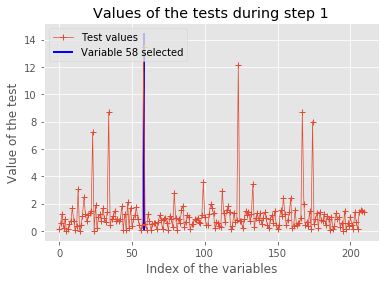

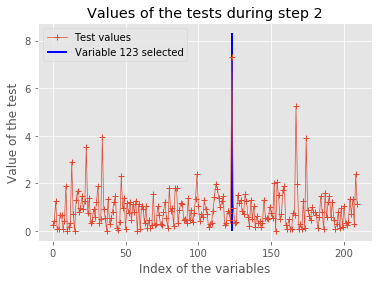

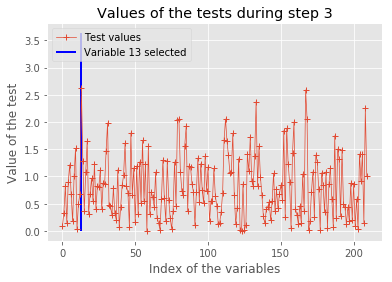

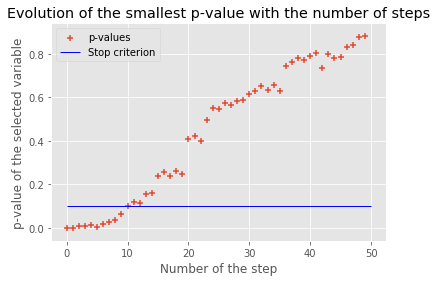

In [18]:
S = forward_variable_selection(training_score,training_set, p_stop = 0.1)
print('The selected variables are : ' + str(S))

Let run $OLS$ on the selected variables. Then we provide the prediction risk for the test sample and compare with those for $OLS$ and $PCA$ before $OLS$.

In [19]:
selected_var = training_set[:, S] #we keep the features selected
ols_sel = LinearRegression().fit(selected_var, training_score)

prediction_sel_ols = ols_sel.predict(test_set[:, S])
residuals_sel_ols = test_score - prediction_sel_ols
sel_ols_prediction_risk = (1/test_set.shape[0]) * np.mean(residuals_sel_ols**2)

print('The prediction risk for the OLS on the selected variables is : ' + str(sel_ols_prediction_risk) + '\n\n' +
      'With OLS on all the variables, we had : ' + str(ols_prediction_risk) + '\n' +
      'With PCA before OLS, we had : ' + str(pca_ols_prediction_risk))

The prediction risk for the OLS on the selected variables is : 37.614886336043504

With OLS on all the variables, we had : 46.74624993915383
With PCA before OLS, we had : 37.75187194992657


<h3> Ridge regression </h3>

To prepare for the cross-validation, we split randomly the train sample in $4$ equal parts (called “folds”).

In [20]:
#we split in two in order to get two sets
first_split = train_test_split(training_set, training_score, test_size = 0.5)

#we split the two previous sets in two in order to get four folds
second_split = train_test_split(first_split[0], first_split[2], test_size = 0.5)
second_split2 = train_test_split(first_split[1], first_split[3], test_size = 0.5)

folds = np.array([second_split[0], second_split[1], second_split2[0], second_split2[1]])
folds_outputs = np.array([second_split[2].reshape(-1, 1), second_split[3].reshape(-1, 1), second_split2[2].reshape(-1, 1), second_split2[3].reshape(-1, 1)])

print('The first fold has : ' + str(folds[0].shape[0]) + ' observations' + '\n' +
      'The second fold has : ' + str(folds[1].shape[0]) + ' observations' + '\n' +
      'The third fold has : ' + str(folds[2].shape[0]) + ' observations' + '\n' +
      'The fourth fold has : ' + str(folds[3].shape[0]) + ' observations' + '\n')

The first fold has : 88 observations
The second fold has : 88 observations
The third fold has : 88 observations
The fourth fold has : 89 observations



Let apply the ridge regression method. For the choice of the regularization parameter, we run the cross validation on the “folds” defined previously. Each “fold” is used to calculate the prediction risk while the resting ones are used for estimating the model. Then the $4$ risks are averaged. We plot the estimated risk curve as a function of the regularization parameter (pay attention when choosing the range for the values of the regularization parameter). Finally, we provide the optimal regularization parameter and the corresponding risk for the test sample.

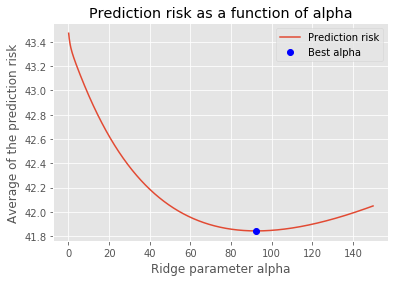

In [21]:
alpha_list = np.arange(0.1, 150, 0.1)

#to store the best values
best_alpha = 0
best_pred_risk = np.inf

nb_folds = len(folds)

pred_risk_plot = []

for a in alpha_list :
    
    s_pred_risk = 0
    
    for k in range(nb_folds) :
        
        #we concatenate three folds to obtain a training set
        idx = [a for a in range(nb_folds) if a != k]
        current_training_set = np.vstack((folds[idx[0]], folds[idx[1]], folds[idx[2]]))
        current_training_outputs = np.vstack((folds_outputs[idx[0]], folds_outputs[idx[1]], folds_outputs[idx[2]]))
        
        ridge_reg = Ridge(alpha = a).fit(current_training_set, current_training_outputs)
        
        ridge_pred = ridge_reg.predict(folds[k])
        res_ridge = ridge_pred - folds_outputs[k]
        
        pred_risk_tmp = (res_ridge**2).mean()/ridge_pred.shape[0]
        s_pred_risk += pred_risk_tmp
        
    s_pred_risk /= nb_folds #we take the average of the prediction risks
    
    if s_pred_risk <= best_pred_risk :
        best_pred_risk = s_pred_risk
        best_alpha = a
    
    pred_risk_plot.append(s_pred_risk)

plt.figure()
plt.xlabel('Ridge parameter alpha')
plt.ylabel('Average of the prediction risk')
plt.title('Prediction risk as a function of alpha')
plt.plot(alpha_list, pred_risk_plot, label = 'Prediction risk')
plt.plot([best_alpha], [best_pred_risk], 'o', c = 'b', label = 'Best alpha')
plt.legend(loc = 'best')
plt.show()

In [22]:
print('The best ridge parameter alpha is equal to : ' + str(best_alpha) + ' and the associated prediction risk is : ' + str(best_pred_risk))

The best ridge parameter alpha is equal to : 92.5 and the associated prediction risk is : 41.84392426358318


<h3> LASSO </h3>

Let use the function <tt>lassoCV</tt> of the library <tt>sklearn</tt>. Then, we provide the corresponding risk.

In [23]:
lasso_reg = LassoCV().fit(training_set, training_score)
res_lasso = test_score - lasso_reg.predict(test_set)
pred_risk_lasso = np.mean(res_lasso**2)/len(res_lasso)
print("The corresponding risk is : " + str(pred_risk_lasso))

The corresponding risk is : 37.48385852879488


Let provide the variables selected by the $LASSO$ and apply the $OLS$ method to the selected variables. This method is called Least-square $LASSO$.

In [24]:
lasso_sel_var = np.where((lasso_reg.coef_ != 0) == True)[0]

print('The variables selected by the LASSO are : ' + str(lasso_sel_var) + '\n' +
      'They are : ' + str(len(lasso_sel_var)) + '\n')

ols_lasso = LinearRegression().fit(training_set[:, lasso_sel_var], training_score)
res_ols_lasso = test_score - ols_lasso.predict(test_set[:, lasso_sel_var])
pred_risk_ols_lasso = np.mean(res_ols_lasso**2)/len(res_ols_lasso)

print('The associated prediction risk is : ' + str(pred_risk_ols_lasso))

The variables selected by the LASSO are : [ 13  58 112 123 159 167 174]
They are : 7

The associated prediction risk is : 37.079514625363586


<h3> Non-linear approach </h3>

This is an outlook for the non-linear approach. Using the variables selected by the $LASSO$, or by the forward selection method, we develop the method of the non-linear regression. We learn the different parameters using the cross-validation and provide the risk for the test sample (it is possible to have worse performance than the $OLS$ method).

In [25]:
c_list = np.arange(0.1, 5, 0.05)
epsilon_list = np.arange(0.1, 3, 0.1)

#to store the best values
best_c = 0
best_epsilon = 0
best_pred_risk_svr = np.inf
nb_folds = len(folds)

#same as previously but we now have two parameters
for i in range(len(c_list)) :
    for j in range(len(epsilon_list)) :
        s_pred_risk_svr = 0
    
        for k in range(nb_folds) :
        
            #we concatenate three folds to obtain a training set
            idx = [a for a in range(nb_folds) if a != k]
            current_training_set = np.vstack((folds[idx[0]], folds[idx[1]], folds[idx[2]]))
            current_training_outputs = np.vstack((folds_outputs[idx[0]], folds_outputs[idx[1]], folds_outputs[idx[2]]))
        
            svr_clf = SVR(C = c_list[i], epsilon = epsilon_list[j]).fit(current_training_set[:, lasso_sel_var], current_training_outputs.ravel())
        
            svr_pred = svr_clf.predict(folds[k][:, lasso_sel_var])
            res_svr = svr_pred - folds_outputs[k]
        
            pred_risk_svr = (res_svr**2).mean()/svr_pred.shape[0]
            s_pred_risk_svr += pred_risk_svr
        
        s_pred_risk_svr /= nb_folds #we take the average of the prediction risks

        if s_pred_risk_svr <= best_pred_risk_svr :
            best_pred_risk_svr = s_pred_risk_svr
            best_c = c_list[i]
            best_epsilon = epsilon_list[j]

In [31]:
display(Markdown('The best C is : ' + str(best_c) + '\n\n' + 
                 'The best $\epsilon$ is : ' + str(best_epsilon)))

The best C is : 0.3500000000000001

The best $\epsilon$ is : 1.9000000000000001

In [32]:
svr_clf = SVR(C = best_c, epsilon = best_epsilon).fit(training_set[:, lasso_sel_var], training_score)
pred_risk_svr = np.mean((test_score - svr_clf.predict(test_set[:, lasso_sel_var]))**2)/len(test_score)

print('With the SVR model and the variables selected by LASSO, the prediction risk is : ' + str(pred_risk_svr))

With the SVR model and the variables selected by LASSO, the prediction risk is : 73.48845493336238


Let gather the prediction risk of each method we have used.

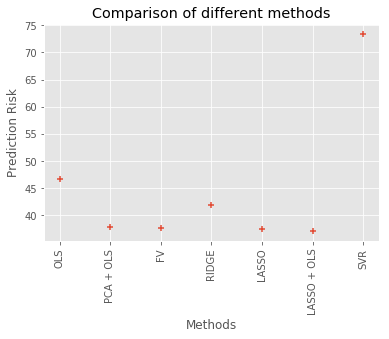

In [33]:
fig = plt.figure()
axes = fig.add_subplot(111)
axes.xaxis.set_ticklabels(['', 'OLS', 'PCA + OLS', 'FV', 'RIDGE', 'LASSO', 'LASSO + OLS', 'SVR'], rotation = 90)
axes.set_title('Comparison of different methods')
axes.set_xlabel('Methods')
axes.set_ylabel('Prediction Risk')
axes.scatter(x = range(7), y = [ols_prediction_risk, pca_ols_prediction_risk, 
                                sel_ols_prediction_risk, best_pred_risk, 
                                pred_risk_lasso, pred_risk_ols_lasso, pred_risk_svr], marker = '+')

We notice that this method is not very effective compared to the others. This means that our output is linearly dependant on the data, and that using a linear model is relevant here.